In [10]:
import json
import pandas as pd
import os
import ast # For safely evaluating string representations of lists
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display # For better rendering in Jupyter

In [11]:
# Base path to the results directory
base_path = os.path.expanduser("~/slimsc/prune/results/R1-Distill-Qwen-14B/aime/")

experiment_runs = [
    "diversity_n64_thresh0.95",
    "diversity_n64_thresh0.98",
    "random_n64_thresh0.95",
    "random_n64_thresh0.98",
    "sc_64_control",
    "sc_32_control",
    "sc_16_control",
    "sc_1_control",
]

# More descriptive names for the table rows
experiment_display_names = {
    "diversity_n64_thresh0.95": "Diversity (n=64, th=0.95)",
    "diversity_n64_thresh0.98": "Diversity (n=64, th=0.98)",
    "random_n64_thresh0.95": "Random (n=64, th=0.95)",
    "random_n64_thresh0.98": "Random (n=64, th=0.98)",
    "sc_64_control": "Self-Consistency (n=64)",
    "sc_32_control": "Self-Consistency (n=32)",
    "sc_16_control": "Self-Consistency (n=16)",
    "sc_1_control": "Self-Consistency (n=1)",
}

results_data = []

In [12]:
def calculate_correct_in_individual(csv_path):
    """
    Calculates the percentage of rows where correct_answer is present in individual_answers_str.
    """
    if not os.path.exists(csv_path):
        print(f"Warning: Evaluation summary file not found at {csv_path}")
        return None
    try:
        df_eval = pd.read_csv(csv_path)
        if df_eval.empty:
            return 0.0

        correct_present_count = 0
        total_rows_parsable = 0

        for _, row in df_eval.iterrows():
            try:
                correct_answer = str(row['correct_answer'])
                individual_answers_str = row['individual_answers_str']

                if pd.isna(individual_answers_str) or not str(individual_answers_str).strip():
                    # Treat as correct answer not present if no individual answers provided
                    individual_answers_list = []
                else:
                    # Ensure it's treated as a string before ast.literal_eval
                    individual_answers_list = ast.literal_eval(str(individual_answers_str))
                
                # Ensure all items in the list are strings for consistent comparison
                individual_answers_list = [str(ans) for ans in individual_answers_list]

                if correct_answer in individual_answers_list:
                    correct_present_count += 1
                total_rows_parsable +=1

            except SyntaxError:
                print(f"Warning: Could not parse individual_answers_str in {csv_path} for question_id: {row.get('question_id', 'N/A')}. Row content: '{individual_answers_str}'")
                # Optionally, decide how to count this row (e.g., skip, or count as not present)
            except Exception as e:
                print(f"Warning: Error processing row in {csv_path} for question_id: {row.get('question_id', 'N/A')}: {e}")

        return (correct_present_count / total_rows_parsable) * 100 if total_rows_parsable > 0 else 0.0
    except Exception as e:
        print(f"Error reading or processing {csv_path}: {e}")
        return None

In [13]:
for run_name in experiment_runs:
    run_path = os.path.join(base_path, run_name)
    agg_metrics_path = os.path.join(run_path, "aggregated_metrics.json")
    eval_summary_path = os.path.join(run_path, "evaluation_summary.csv")

    display_name = experiment_display_names.get(run_name, run_name)
    run_metrics = {"experiment": display_name}

    # Default values for metrics from aggregated_metrics.json
    overall_accuracy = float("NaN")
    mean_total_completion_tokens = float("NaN")
    mean_processing_duration = float("NaN")
    mean_chains_completed = float("NaN")

    if os.path.exists(agg_metrics_path):
        try:
            with open(agg_metrics_path, 'r') as f:
                agg_data = json.load(f)
            metrics = agg_data.get("metrics", {})

            overall_accuracy = float(metrics.get("overall_accuracy", "NaN"))
            mean_total_completion_tokens = float(metrics.get("mean_total_completion_tokens_per_question", "NaN"))
            mean_processing_duration = float(metrics.get("mean_processing_duration_sec_per_question", "NaN"))

            # Determine mean_chains_completed based on available keys
            if "mean_chains_completed_stream_for_voting_per_question" in metrics:
                mean_chains_completed = float(metrics.get("mean_chains_completed_stream_for_voting_per_question", "NaN"))
            elif "mean_chains_received_per_question" in metrics:  # For SC control runs
                mean_chains_completed = float(metrics.get("mean_chains_received_per_question", "NaN"))
            # For sc_1_control, if received is not present, started/requested (usually 1) is a good proxy
            elif run_name == "sc_1_control":
                if "mean_chains_started_per_question" in metrics:
                     mean_chains_completed = float(metrics.get("mean_chains_started_per_question", "NaN"))
                elif "mean_chains_requested_per_question" in metrics: # Fallback for sc_1_control
                     mean_chains_completed = float(metrics.get("mean_chains_requested_per_question", "NaN"))

        except json.JSONDecodeError:
            print(f"Error decoding JSON from {agg_metrics_path}")
        except ValueError as ve:
            print(f"ValueError converting data from {agg_metrics_path}: {ve}")
        except Exception as e:
            print(f"An unexpected error occurred while processing {agg_metrics_path}: {e}")
    else:
        print(f"Warning: Aggregated metrics file not found at {agg_metrics_path}")

    run_metrics["overall_accuracy"] = overall_accuracy
    run_metrics["mean_total_completion_tokens_per_question"] = mean_total_completion_tokens
    run_metrics["mean_processing_duration_sec_per_question"] = mean_processing_duration
    run_metrics["mean_chains_completed_for_voting_per_question"] = mean_chains_completed
    
    # Extract from evaluation_summary.csv
    perc_correct_in_individual = calculate_correct_in_individual(eval_summary_path)
    run_metrics["perc_correct_in_individual_answers"] = perc_correct_in_individual if perc_correct_in_individual is not None else float("NaN")

    results_data.append(run_metrics)

In [14]:
df_comparison = pd.DataFrame(results_data)
df_comparison = df_comparison.set_index("experiment")

# Rename the column for clarity as requested
df_comparison = df_comparison.rename(columns={
    "mean_chains_completed_for_voting_per_question": "mean_chains_completed_stream_for_voting_per_question"
})


print("Comparison of Experiment Metrics:")
styled_df = df_comparison.style.format({
    "overall_accuracy": "{:.4f}",
    "mean_total_completion_tokens_per_question": "{:,.1f}",
    "mean_processing_duration_sec_per_question": "{:,.2f}",
    "mean_chains_completed_stream_for_voting_per_question": "{:,.1f}",
    "perc_correct_in_individual_answers": "{:.2f}%"
}, na_rep="N/A").highlight_max(axis=0, props='background-color: lightgreen; color: black;').highlight_min(axis=0, props='background-color: pink; color: black;')

display(styled_df)

Comparison of Experiment Metrics:


,overall_accuracy,mean_total_completion_tokens_per_question,mean_processing_duration_sec_per_question,mean_chains_completed_stream_for_voting_per_question,perc_correct_in_individual_answers
experiment,,,,,
"Diversity (n=64, th=0.95)",0.8333,"305,243.3",396.64,20.8,83.33%
"Diversity (n=64, th=0.98)",0.8000,"414,164.0",582.54,33.7,83.33%
"Random (n=64, th=0.95)",0.7667,"300,946.1",399.29,21.7,80.00%
"Random (n=64, th=0.98)",0.8333,"382,406.7",507.92,32.4,83.33%
Self-Consistency (n=64),0.8300,"563,161.3",677.40,63.8,86.67%
Self-Consistency (n=32),0.8000,"277,037.6",634.62,31.6,90.00%
Self-Consistency (n=16),0.7700,"147,614.2",445.30,16.0,83.33%
Self-Consistency (n=1),0.7300,"9,794.1",192.40,1.0,73.33%


/tmp/ipykernel_417829/1368299589.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='experiment', y=metric_col, data=plot_data, palette='viridis')
/tmp/ipykernel_417829/1368299589.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='experiment', y=metric_col, data=plot_data, palette='viridis')
/tmp/ipykernel_417829/1368299589.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='experiment', y=metric_col, data=plot_data, palette='viridis')
/tmp/ipykernel_417829/1368299589.py:23: FutureWarning: 

Passing

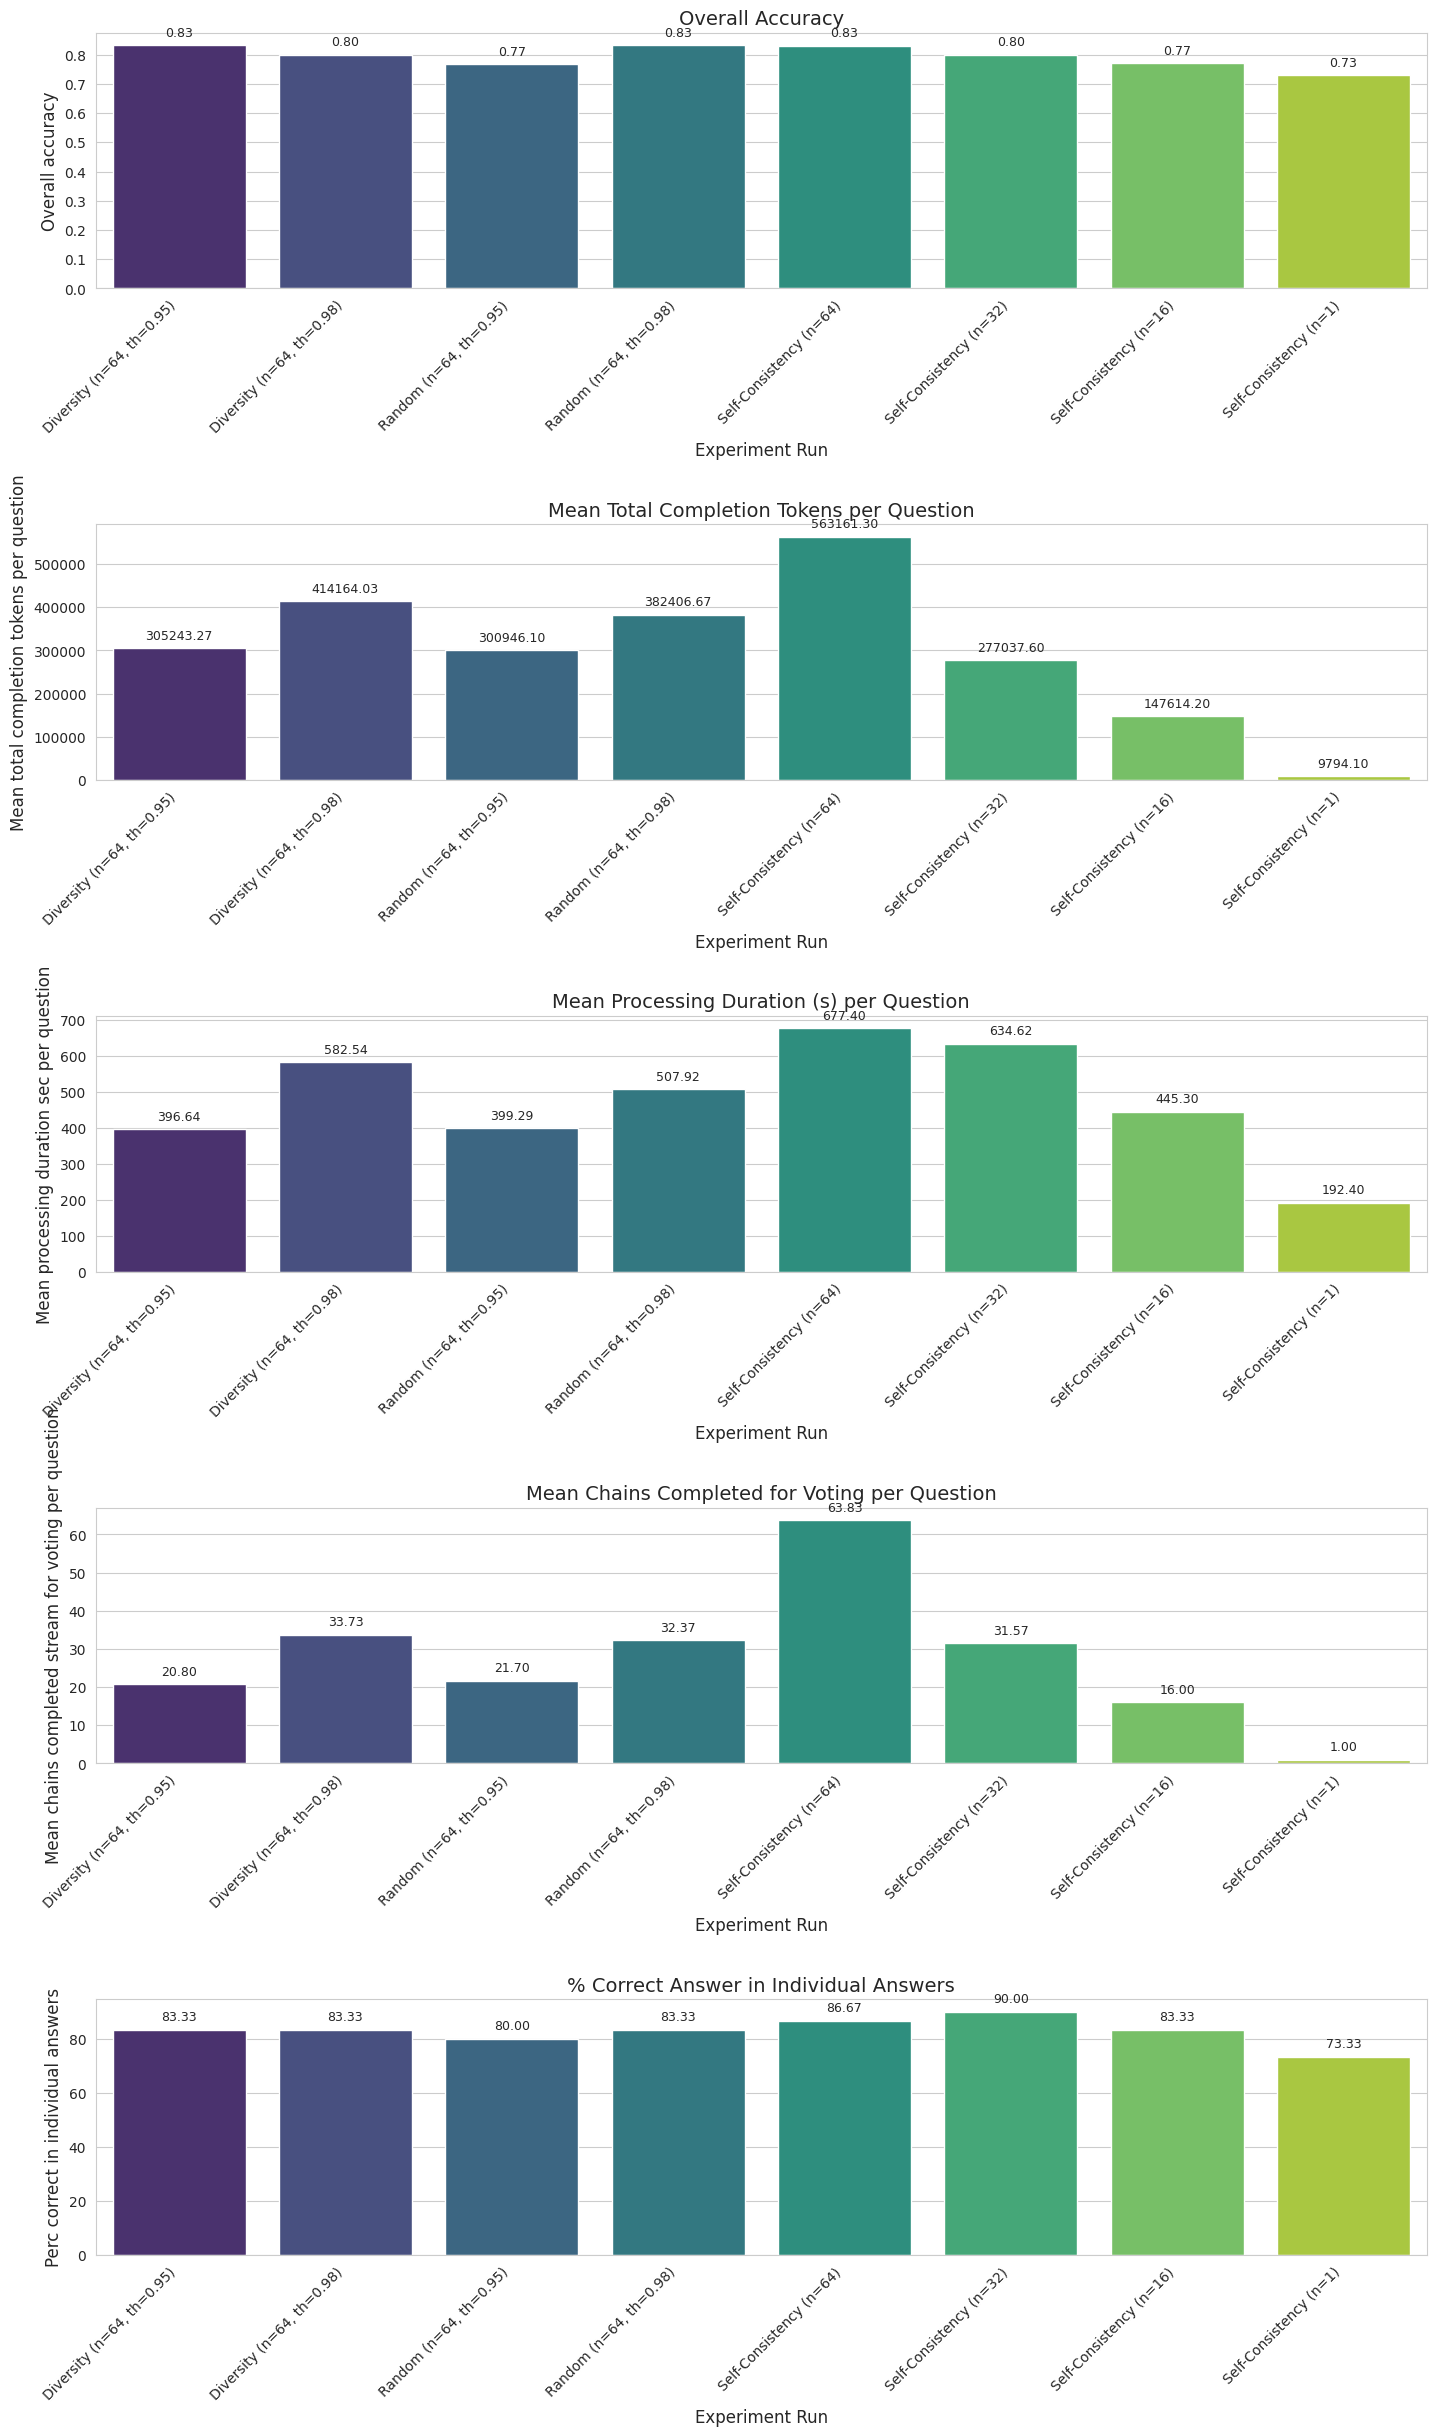

In [15]:
# Set a pleasant style for plots
sns.set_style("whitegrid")

# Metrics to plot
metrics_to_plot = {
    "overall_accuracy": "Overall Accuracy",
    "mean_total_completion_tokens_per_question": "Mean Total Completion Tokens per Question",
    "mean_processing_duration_sec_per_question": "Mean Processing Duration (s) per Question",
    "mean_chains_completed_stream_for_voting_per_question": "Mean Chains Completed for Voting per Question",
    "perc_correct_in_individual_answers": "% Correct Answer in Individual Answers"
}

num_metrics = len(metrics_to_plot)
plt.figure(figsize=(15, num_metrics * 5)) # Adjust figure size based on number of plots

for i, (metric_col, title) in enumerate(metrics_to_plot.items()):
    plt.subplot(num_metrics, 1, i + 1) # Create a subplot for each metric
    
    # Handle NaN for plotting by either filtering or letting seaborn manage (it usually does)
    plot_data = df_comparison[[metric_col]].copy().dropna().reset_index()

    if not plot_data.empty:
        barplot = sns.barplot(x='experiment', y=metric_col, data=plot_data, palette='viridis')
        plt.title(title, fontsize=14)
        plt.xlabel('Experiment Run', fontsize=12)
        plt.ylabel(metric_col.replace("_", " ").capitalize(), fontsize=12)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.yticks(fontsize=10)
        
        # Add data labels on top of bars
        for p in barplot.patches:
            barplot.annotate(format(p.get_height(), '.2f'), 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', 
                           xytext = (0, 9), 
                           textcoords = 'offset points', fontsize=9)
    else:
        plt.text(0.5, 0.5, 'No data available for this metric.', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)


plt.tight_layout(pad=3.0) # Add padding between subplots
plt.show()